In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omanildoiphode","key":"a71a74b363179c672120a1fec6b4a285"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download shawngano/gano-cat-breed-image-collection

Dataset URL: https://www.kaggle.com/datasets/shawngano/gano-cat-breed-image-collection
License(s): CC-BY-SA-4.0
 98% 249M/254M [00:03<00:00, 77.2MB/s]
100% 254M/254M [00:03<00:00, 79.3MB/s]


In [ ]:
!unzip /content/gano-cat-breed-image-collection.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow import keras
from keras.layers import *
from keras.models import Model

In [ ]:
import os
import pathlib
from glob import glob

In [ ]:
PATH='/content/Gano-Cat-Breeds-V1_1'

In [ ]:
def make_dataFrame(data):
    path=pathlib.Path(data)
    filepaths=list(path.glob(r"*/*.jpg"))
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
    d1=pd.Series(filepaths,name='filepaths').astype(str)
    d2=pd.Series(labels,name='labels')
    df=pd.concat([d1,d2],axis=1)
    return df

In [ ]:
dataset = make_dataFrame(PATH)
dataset

,filepaths,labels
0,/content/Gano-Cat-Breeds-V1_1/Ragdoll/Ragdoll_...,Ragdoll
1,/content/Gano-Cat-Breeds-V1_1/Ragdoll/Ragdoll_...,Ragdoll
2,/content/Gano-Cat-Breeds-V1_1/Ragdoll/Ragdoll-...,Ragdoll
3,/content/Gano-Cat-Breeds-V1_1/Ragdoll/Ragdoll_...,Ragdoll
4,/content/Gano-Cat-Breeds-V1_1/Ragdoll/Ragdoll-...,Ragdoll
...,...,...
5620,/content/Gano-Cat-Breeds-V1_1/Bengal/Bengal_10...,Bengal
5621,/content/Gano-Cat-Breeds-V1_1/Bengal/Bengal_16...,Bengal
5622,/content/Gano-Cat-Breeds-V1_1/Bengal/Bengal-25...,Bengal
5623,/content/Gano-Cat-Breeds-V1_1/Bengal/Bengal-19...,Bengal


In [ ]:
class_names = dataset['labels'].unique()
class_names

array(['Ragdoll', 'British Shorthair', 'Bombay', 'American Shorthair',
       'Russian Blue', 'Persian', 'Abyssinian', 'Siamese', 'Birman',
       'American Bobtail', 'Maine Coon', 'Egyptian Mau', 'Tuxedo',
       'Sphynx', 'Bengal'], dtype=object)

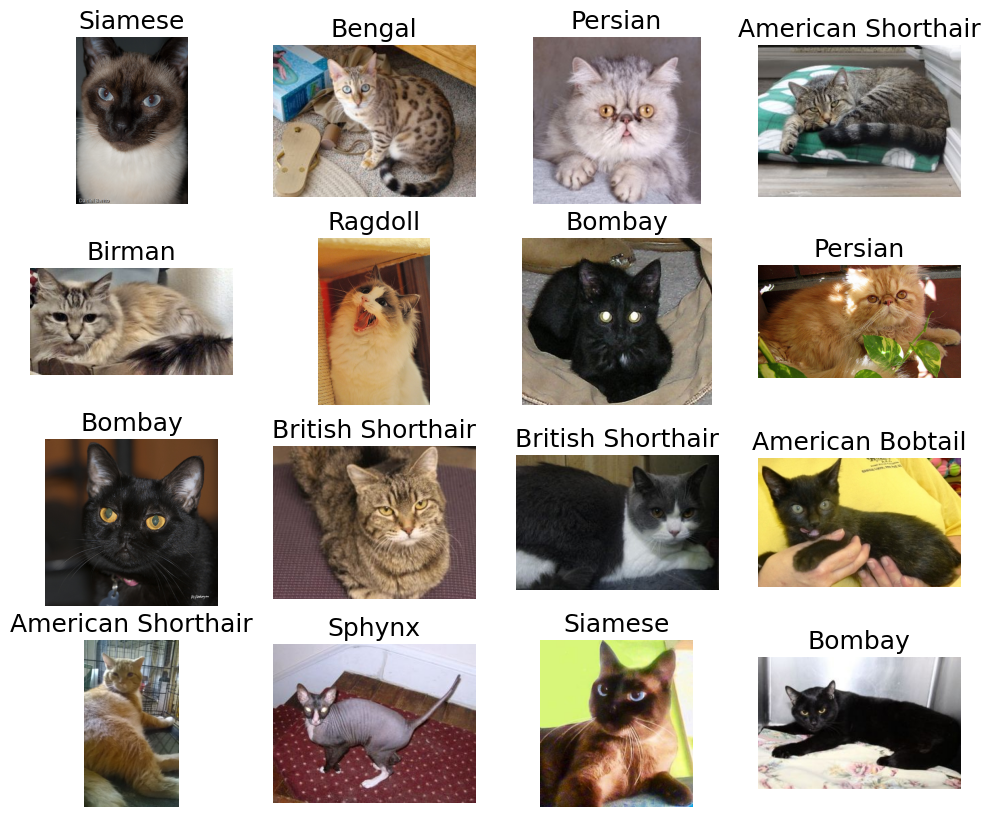

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,10))
for i,ax in enumerate(axes.flat):
    idx = np.random.randint(1,5624)
    x = plt.imread(dataset.iloc[idx]['filepaths'])
    ax.imshow(x)
    ax.set_title(dataset['labels'][idx], fontsize=18)
    ax.set_axis_off()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(dataset, test_size=0.2, stratify=dataset['labels'], random_state=42)

# Create ImageDataGenerator for training and validation
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.2  # specify the validation split here
)

val_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

# Create training dataset
train_dataset = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    subset='training',
    shuffle=True
)

# Create validation dataset
val_dataset = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3600 validated image filenames belonging to 15 classes.
Found 1125 validated image filenames belonging to 15 classes.


In [ ]:
base_model = keras.applications.ResNet50V2(include_top=False,
                                            weights='imagenet',
                                            pooling='avg')
base_model.trainable = False

i = Input(shape=(224,224,3))
x = base_model(i, training=False)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(len(class_names), activation='softmax')(x)

model = Model(i,x)


94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                            mode='min',
                                            patience=3)]
)

Epoch 1/20
113/113 [==============================] - 30s 180ms/step - loss: 1.4904 - accuracy: 0.5272 - val_loss: 0.9116 - val_accuracy: 0.7013
Epoch 2/20
113/113 [==============================] - 17s 149ms/step - loss: 0.9738 - accuracy: 0.6753 - val_loss: 0.8335 - val_accuracy: 0.7289
Epoch 3/20
113/113 [==============================] - 16s 139ms/step - loss: 0.8208 - accuracy: 0.7264 - val_loss: 0.7915 - val_accuracy: 0.7440
Epoch 4/20
113/113 [==============================] - 18s 155ms/step - loss: 0.7259 - accuracy: 0.7531 - val_loss: 0.7906 - val_accuracy: 0.7129
Epoch 5/20
113/113 [==============================] - 16s 146ms/step - loss: 0.6732 - accuracy: 0.7656 - val_loss: 0.7741 - val_accuracy: 0.7333
Epoch 6/20
113/113 [==============================] - 17s 152ms/step - loss: 0.5835 - accuracy: 0.7922 - val_loss: 0.7782 - val_accuracy: 0.7218
Epoch 7/20
113/113 [==============================] - 17s 146ms/step - loss: 0.5689 - accuracy: 0.7933 - val_loss: 0.7755 - val_ac

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def predict_cat_breed(image, model):
    img = tf.keras.preprocessing.image.load_img(image)
    img_arr = tf.keras.utils.img_to_array(img)
    img_arr = img_arr/255.
    img_arr = tf.image.resize(img_arr,[224,224])
    pred = np.argmax(model.predict(np.expand_dims(img_arr, axis=0)))
    prediction = class_names[pred]

    plt.figure(figsize=(2,2), dpi=200)
    plt.imshow(img)
    plt.title(prediction, fontsize=12)
    plt.axis('off')

1/1 [==============================] - 2s 2s/step


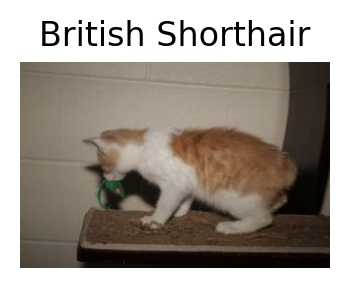

In [ ]:
import tensorflow as tf

image = '/content/Gano-Cat-Breeds-V1_1/American Bobtail/AmericanBobtail-20352057_4257.jpg'
predict_cat_breed(image=image, model=model)

In [ ]:
# Save the entire model to a file
model.save('/content/models/my_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
new_model = load_model('/content/models/my_model.h5')

1/1 [==============================] - 1s 773ms/step


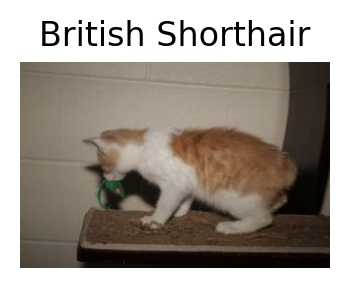

In [ ]:
import tensorflow as tf

image = '/content/Gano-Cat-Breeds-V1_1/American Bobtail/AmericanBobtail-20352057_4257.jpg'
predict_cat_breed(image=image, model=new_model)

In [ ]:
!git clone https://github.com/Om-Doiphode/Dog-Breed-Classifier.git

Cloning into 'Dog-Breed-Classifier'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 56 (delta 13), reused 50 (delta 10), pack-reused 0
Receiving objects: 100% (56/56), 12.63 KiB | 12.63 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [ ]:
%cd /content/Dog-Breed-Classifier

/content/Dog-Breed-Classifier


In [ ]:
!pip install -r requirements.txt

Obtaining file:///content/Dog-Breed-Classifier (from -r requirements.txt (line 19))
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.6/452.6 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.0/426.0 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%cd /content/Dog-Breed-Classifier

/content/Dog-Breed-Classifier


In [ ]:
!python main.py

[2024-07-27 13:51:40,419: INFO: utils: NumExpr defaulting to 2 threads.]
2024-07-27 13:51:41.732149: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 13:51:41.732206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 13:51:41.733571: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-27 13:51:41.740677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropri

In [ ]:
!export KAGGLE_USERNAME=omanildoiphode
!export KAGGLE_KEY=a71a74b363179c672120a1fec6b4a285

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'omanildoiphode'  # Replace with your Kaggle username
os.environ['KAGGLE_KEY'] = 'a71a74b363179c672120a1fec6b4a285'  # Replace with your Kaggle API key

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/Dog-Breed-Classifier/artifacts/training')